### Single decision tree.
#### Semester work for NI-ADM from student Syzon Yuliia.

This experimental section is dedicated to the basic implementation of the standard decision tree which is part of my diploma thesis - Single decision tree. This thesis is a subject of cooperation with open source division of company H2O.ai  (cooperation with industry). 

The classic decision tree is implemented with some temporary simplifications. This part of the work is limited to binary classification task only. Entropy is used while selecting best split for each node. Max depth is the main stop criteria in tree building. Also, the classes' ratio is used as stop criteria - when the class ratio is less than 1:9 or 9:1, splitting is stopped. I also stop splitting when there are not enough samples in the node. I work with all features as they are double values, so the splitting is done by selecting threshold and feature and splitting data to 2 parts - where selected feature is less or equal to threshold and where it is bigger than the threshold. 

For optimisation the binning technic is used. Currently, only equal-with strategy is implemented. The data range is split to N bins and for each bin I calculate count of samples and count of predictions of one class, so I am able to compute entropy of splits. After each step I recalculate features' limits to avoid empty bins. 

The experimental section compares my solution with two another implementations of decision tree:
 - Distributed Random Forest - algorithm implemented in H2O.ai, the integration and infrastructure is identical to my solution. I set the count of trees to one, so I get one decision tree. 
 - Scikit-learn decision tree - standard implementation of decision tree in python. All hyperparameters are set to be the same as in my algorithm. 


For this report I already prepared predictions of all algorithms. I used 2 datasets - prostate and airlines. Both of datasets contain binary prediction variable. The airlines dataset was preprocessed by me, so it contains only transformed numeric features. Class' counts in prostate dataset (train set): 0 - 184, 1 - 120, class' counts in airlines dataset (train set): 0 - 11066, 1 - 13355. 


On the plots below I displayed some metrics depending on the max_depth of tree. I considered following values of max_depth: 2, 5, 7, 10, 15, 20. Metrics are accuracy, precision, recall and f1-score.

My algorithm performed comparably good on both datasets. 

Also, I experimented with scalability. I compared how good are predictions when using different sizes of dataset - from 100 to 100k samples. I also compared a time needed for model training and making predictions when using different size of dataset. I compared times with another solution - H2O distributed random forest with one tree. I run each configuration 3 times to show statistics on the average value.


In [57]:
import pandas as pd
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [58]:
def get_predictions_for_model(model, max_depth, data_train, data_test, prediction_column, dataset):
    if model == "h2o-sdt":
        return pd.read_csv("../../h2o-algos/predictions_" + dataset + "_sdt_depth" + str(max_depth) + ("_" if (dataset == "prostate") else "") + ".csv")[prediction_column]

    
    if model == "h2o-drf":
        return pd.read_csv("../../h2o-algos/predictions_" + dataset + "_drf_depth" + str(max_depth) + ".csv")[prediction_column]
    
    
    if model == "sklearn-dtc":
        clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, min_samples_split=3).fit(data_train.drop([prediction_column], axis=1), data_train[prediction_column])
        return clf.predict(data_test.drop([prediction_column], axis=1))
        

In [59]:
def evaluate_models(dataset_name, train_filename, test_filename, prediction_column):
    train = pd.read_csv(train_filename)
    test = pd.read_csv(test_filename)
    y_true = test[prediction_column]
    metrics = {"accuracy": {"h2o-sdt": list(), "h2o-drf": list(), "sklearn-dtc": list()},
               "precision": {"h2o-sdt": list(), "h2o-drf": list(), "sklearn-dtc": list()},
               "recall": {"h2o-sdt": list(), "h2o-drf": list(), "sklearn-dtc": list()},
               "f1": {"h2o-sdt": list(), "h2o-drf": list(), "sklearn-dtc": list()}}
    depths = [2, 5, 7, 10, 15, 20]
    for model in ["h2o-sdt", "h2o-drf", "sklearn-dtc"]:
        for depth in depths:
            y_pred = get_predictions_for_model(model, depth, train, test, prediction_column, dataset_name)
            metrics["accuracy"][model].append(accuracy_score(y_true, y_pred))
            metrics["precision"][model].append(precision_score(y_true, y_pred, zero_division=True))
            metrics["recall"][model].append(recall_score(y_true, y_pred))
            metrics["f1"][model].append(f1_score(y_true, y_pred))

    fig = plt.figure(figsize=(20, 10))
    fig.suptitle("Evaluation on " + dataset_name + " dataset", fontsize=20)

    # plt.title("Evaluation on " + dataset_name + " dataset")
    current_subplot = 221
    for metric in ["accuracy", "precision", "recall", "f1"]:
        plt.subplot(current_subplot, title=metric, xlabel='max depth', ylabel='metric')
        current_subplot += 1
        plt.plot(depths, metrics[metric]["h2o-sdt"], linestyle='--', marker='o', color='b', label="h2o-sdt")
        # plt.yticks(metrics[metric]["h2o-sdt"])

        plt.plot(depths, metrics[metric]["h2o-drf"], linestyle='--', marker='o', color='y', label="h2o-drf")
        # plt.yticks(metrics[metric]["h2o-drf"])
        plt.plot(depths, metrics[metric]["sklearn-dtc"], linestyle='--', marker='o', color='g', label="sklearn-dtc")
        # plt.yticks(metrics[metric]["sklearn-dtc"])
        plt.xticks(depths)
        plt.legend()
    plt.show()


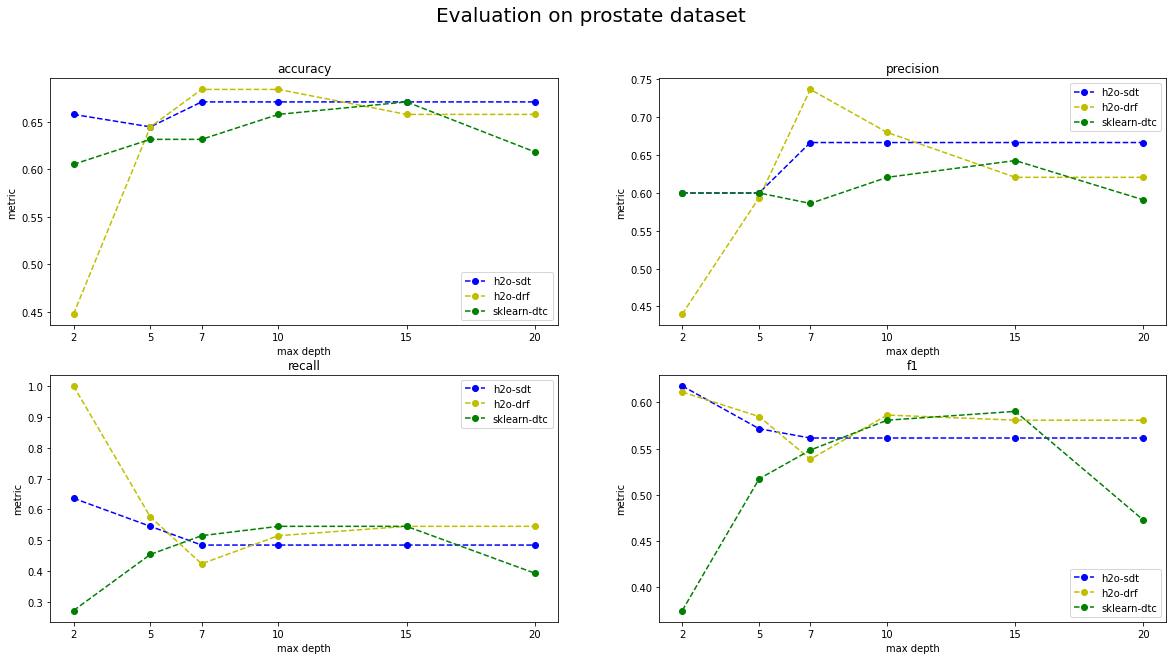

In [60]:
# evaluate_models_prostate()
evaluate_models("prostate", "../../smalldata/prostate/prostate_train.csv", "../../smalldata/prostate/prostate_test.csv", 'CAPSULE')

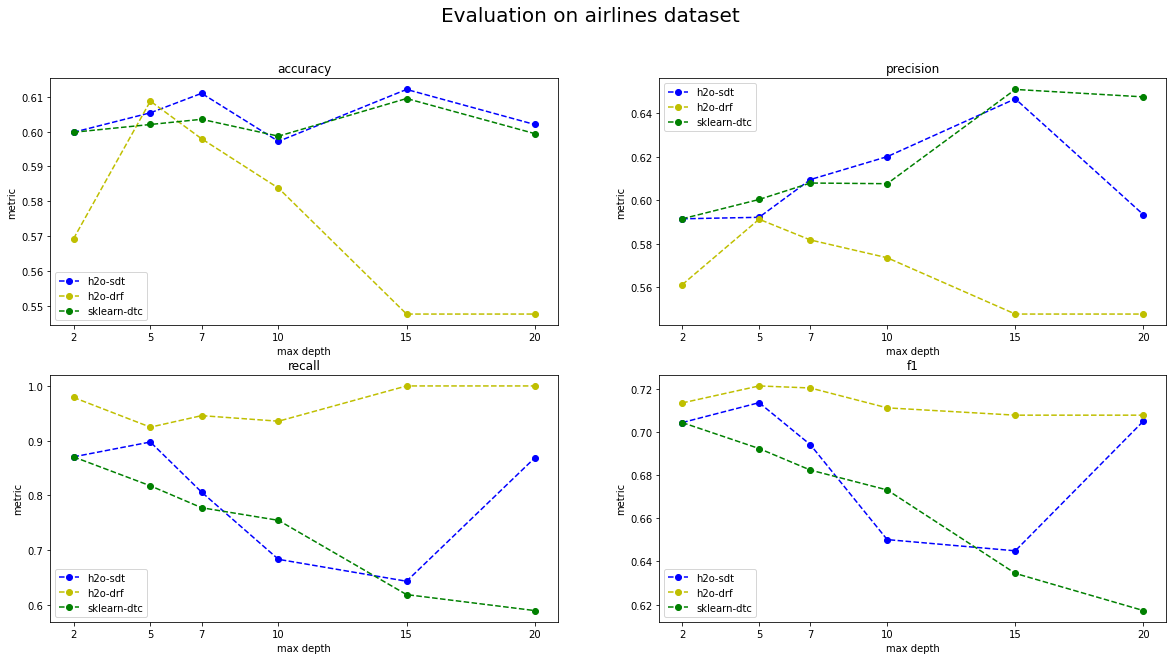

In [61]:
# evaluate_models_airlines()
evaluate_models("airlines", "../../smalldata/testng/airlines_train_preprocessed.csv", "../../smalldata/testng/airlines_test_preprocessed.csv", 'IsDepDelayed')

##### Scalability

In [62]:
def preprocess_airlines_data(data: pd.DataFrame):
    data.IsDepDelayed = data.IsDepDelayed.apply(lambda v: v if v in [0, 1] else (1 if v == 'YES' else 0))
    unique_carrier = list(data.UniqueCarrier.unique())
    data.UniqueCarrier = data.UniqueCarrier.apply(lambda v: unique_carrier.index(v) if v in unique_carrier else v)
    origin = list(data.Origin.unique())
    data.Origin = data.Origin.apply(lambda v: origin.index(v) if v in origin else v)
    dest = list(data.Dest.unique())
    data.Dest = data.Dest.apply(lambda v: dest.index(v) if v in dest else v)
    return data

In [89]:
def save_preprocessed_sample_split(sample_size):
    data_sample = full_data_100k.sample(sample_size, random_state=135) # so data splits the same each time
    # data_sample = preprocess_airlines_data(data_sample)
    train, test = train_test_split(data_sample, train_size=0.8)
    # train = preprocess_airlines_data(train)
    # test = preprocess_airlines_data(test)
    print(train)
    train.to_csv(path_to_data + "airlines_train_" + str(sample_size) + ".csv", index=False)
    test.to_csv(path_to_data + "airlines_test_" + str(sample_size) + ".csv", index=False)
    # return train, test
    # return [preprocess_airlines_data(train_test) for train_test in train_test_split(data_sample, train_size=0.7)]

In [91]:
sample_sizes = [100, 500, 1000, 5000, 10000, 27112]
# path_to_data = "../../smalldata/airlines/"
# full_data_100k = pd.read_csv(path_to_data + "airlines_all_100k.csv")[['IsDepDelayed','Year','Month','DayofMonth','DayOfWeek','UniqueCarrier','Origin','Dest','Distance']]
path_to_data = "../../smalldata/testng/"
full_data_100k = pd.concat([pd.read_csv(path_to_data + "airlines_train_preprocessed.csv"), pd.read_csv(path_to_data + "airlines_test_preprocessed.csv")], axis=0)
print(len(full_data_100k))
for size in sample_sizes:
    save_preprocessed_sample_split(size)


27112
       IsDepDelayed  fYear  fMonth  fDayofMonth  fDayOfWeek  UniqueCarrier  \
17882             0   1995       1            1           7              5   
10118             1   1995       1            8           7              3   
8350              1   1993       1           30           6              3   
19495             1   1987      10            7           3              0   
1571              0   1998       1           22           4              4   
...             ...    ...     ...          ...         ...            ...   
6129              0   1988       1           30           6              0   
15074             0   1996       1           13           6              7   
10802             0   1998       1            8           4              7   
22333             1   1992       1           13           1              3   
12821             0   1997       1            8           3              7   

       Origin  Dest  Distance  
17882      69    50      

In [92]:
def get_scalability_for_model(model, sample_size, data_train, data_test, prediction_column):
    if model == "h2o-sdt":
        return pd.read_csv("../../h2o-algos/predictions_airlines_sdt_size" + str(sample_size) + ".csv")[prediction_column]

    if model == "h2o-drf":
        return pd.read_csv("../../h2o-algos/predictions_airlines_drf_size" + str(sample_size) + ".csv")[prediction_column]
    
    if model == "sklearn-dtc":
        clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=3).fit(data_train.drop([prediction_column], axis=1), data_train[prediction_column])
        return clf.predict(data_test.drop([prediction_column], axis=1))
    

In [93]:
def evaluate_models_scalability():
    prediction_column = 'IsDepDelayed'
    metrics = {"accuracy": {"h2o-sdt": list(), "h2o-drf": list(), "sklearn-dtc": list()},
               "precision": {"h2o-sdt": list(), "h2o-drf": list(), "sklearn-dtc": list()},
               "recall": {"h2o-sdt": list(), "h2o-drf": list(), "sklearn-dtc": list()},
               "f1": {"h2o-sdt": list(), "h2o-drf": list(), "sklearn-dtc": list()}}
    for model in ["h2o-sdt", "h2o-drf", "sklearn-dtc"]:
        for sample_size in sample_sizes:
            train = pd.read_csv(path_to_data + "airlines_train_" + str(sample_size) + ".csv")
            test = pd.read_csv(path_to_data + "airlines_test_" + str(sample_size) + ".csv")
            y_true = test[prediction_column]
            y_pred = get_scalability_for_model(model,sample_size, train, test, prediction_column)
            metrics["accuracy"][model].append(accuracy_score(y_true, y_pred))
            metrics["precision"][model].append(precision_score(y_true, y_pred, zero_division=True))
            metrics["recall"][model].append(recall_score(y_true, y_pred))
            metrics["f1"][model].append(f1_score(y_true, y_pred))

    fig = plt.figure(figsize=(20, 10))
    fig.suptitle("Evaluation of scalability", fontsize=20)
    current_subplot = 221
    for metric in ["accuracy", "precision", "recall", "f1"]:
        plt.subplot(current_subplot, title=metric)
        current_subplot += 1
        plt.plot(sample_sizes, metrics[metric]["h2o-sdt"], linestyle='--', marker='o', color='b', label="h2o-sdt")
        # plt.yticks(metrics[metric]["h2o-sdt"])

        plt.plot(sample_sizes, metrics[metric]["h2o-drf"], linestyle='--', marker='o', color='y', label="h2o-drf")
        # plt.yticks(metrics[metric]["h2o-drf"])
        plt.plot(sample_sizes, metrics[metric]["sklearn-dtc"], linestyle='--', marker='o', color='g', label="sklearn-dtc")
        # plt.yticks(metrics[metric]["sklearn-dtc"])
        plt.xticks(sample_sizes)
        plt.legend()
        plt.xscale('log')
    plt.show()

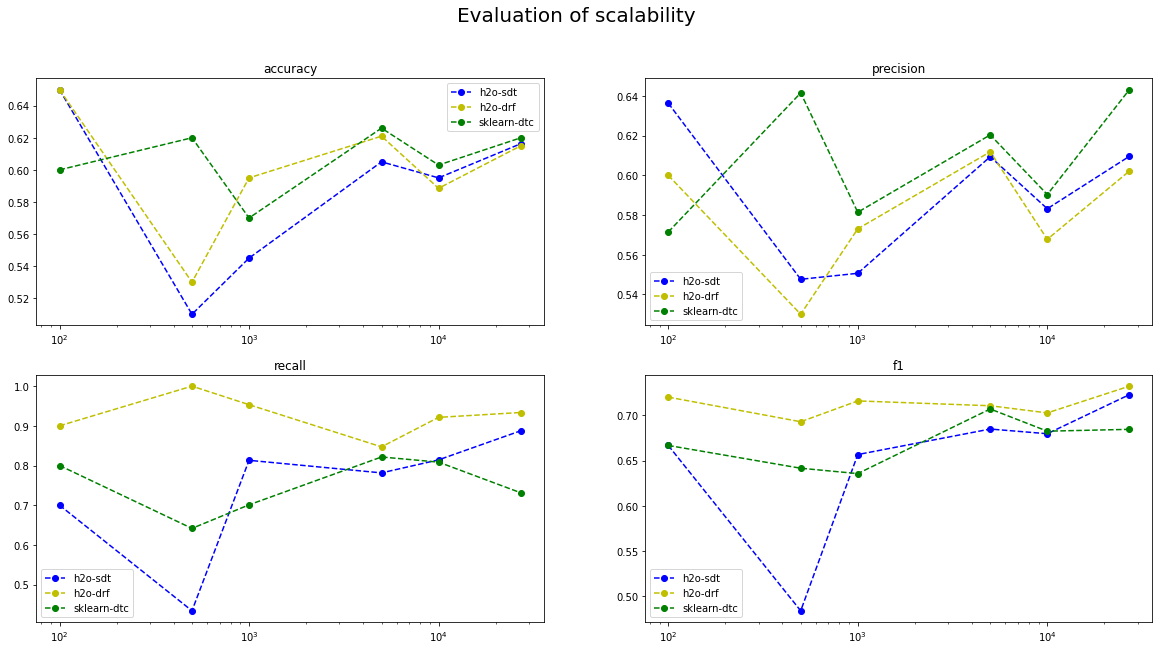

In [96]:
evaluate_models_scalability()

In [68]:
def evaluate_time_scalability():
    # measured times for std in 3 runs
    times_sdt = [
        {"train": [3339, 2753, 2508], "test": [46, 50, 51]}, 
        {"train": [4688, 2661, 3589], "test": [83, 58, 105]}, 
        {"train": [3569, 2341, 3751], "test": [50, 53, 117]}, 
        {"train": [5770, 5120, 6713], "test": [107, 56, 111]}, 
        {"train": [6909, 6707, 8044], "test": [84, 73, 82]}, 
        {"train": [26455, 22431, 22301], "test": [71, 74, 70]}, 
        {"train": [34197, 33756, 34101], "test": [86, 94, 92]},  
             ]

    # measured times for drf in 3 runs
    times_drf = [
        {"train": [577, 598, 476], "test": [33, 49, 104]},
        {"train": [1044, 463, 682], "test": [51, 179, 39]},
        {"train": [551, 778, 514], "test": [57, 59, 142]},
        {"train": [669, 519, 647], "test": [64, 153, 69]},
        {"train": [576, 661, 898], "test": [132, 81, 136]},
        {"train": [727, 811, 840], "test": [212, 272, 375]},
        {"train": [832, 893, 1019], "test": [338, 346, 320]},
    ]
    mean_times_train_sdt = [sum(sample_size_times["train"]) / 3 for sample_size_times in times_sdt]
    mean_times_test_sdt = [sum(sample_size_times["test"]) / 3 for sample_size_times in times_sdt]
    mean_times_train_drf = [sum(sample_size_times["train"]) / 3 for sample_size_times in times_drf]
    mean_times_test_drf = [sum(sample_size_times["test"]) / 3 for sample_size_times in times_drf]

    fig = plt.figure(figsize=(20, 10))
    fig.suptitle("Time scalability - sdt", fontsize=20)
    
    # sdt
    plt.subplot(121, title="train", xlabel='data count', ylabel='time in milliseconds')
    plt.plot(sample_sizes, mean_times_train_sdt, linestyle='--', marker='o', color='b', label='train time')
    plt.xscale('log')
    plt.legend()
    plt.subplot(122, title="test", xlabel='data count', ylabel='time in milliseconds')
    plt.plot(sample_sizes, mean_times_test_sdt, linestyle='--', marker='o', color='b', label='test time')
    plt.legend()
    plt.xscale('log')

    fig1 = plt.figure(figsize=(20, 10))
    fig1.suptitle("Time scalability - drf", fontsize=20)
    # drf
    plt.subplot(121, title="train", xlabel='data count', ylabel='time in milliseconds')
    plt.plot(sample_sizes, mean_times_train_drf, linestyle='--', marker='o', color='b', label='train time')
    plt.xscale('log')
    plt.legend()
    plt.subplot(122, title="test", xlabel='data count', ylabel='time in milliseconds')
    plt.plot(sample_sizes, mean_times_test_drf, linestyle='--', marker='o', color='b', label='test time')
    plt.legend()
    plt.xscale('log')
    
    plt.show()

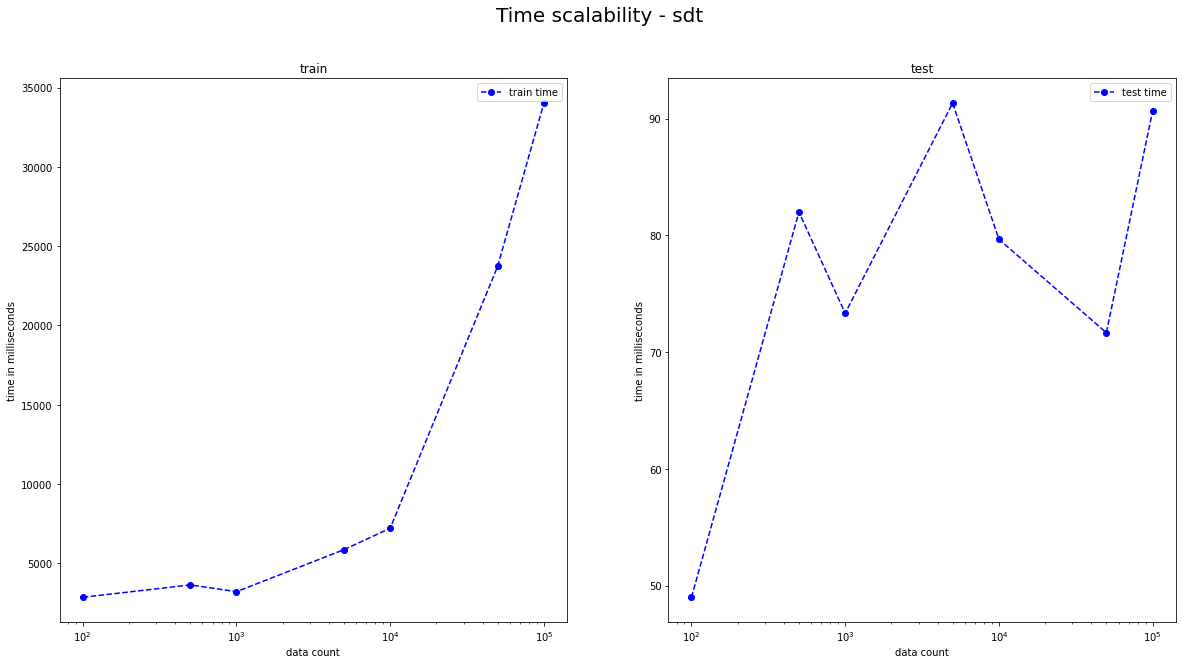

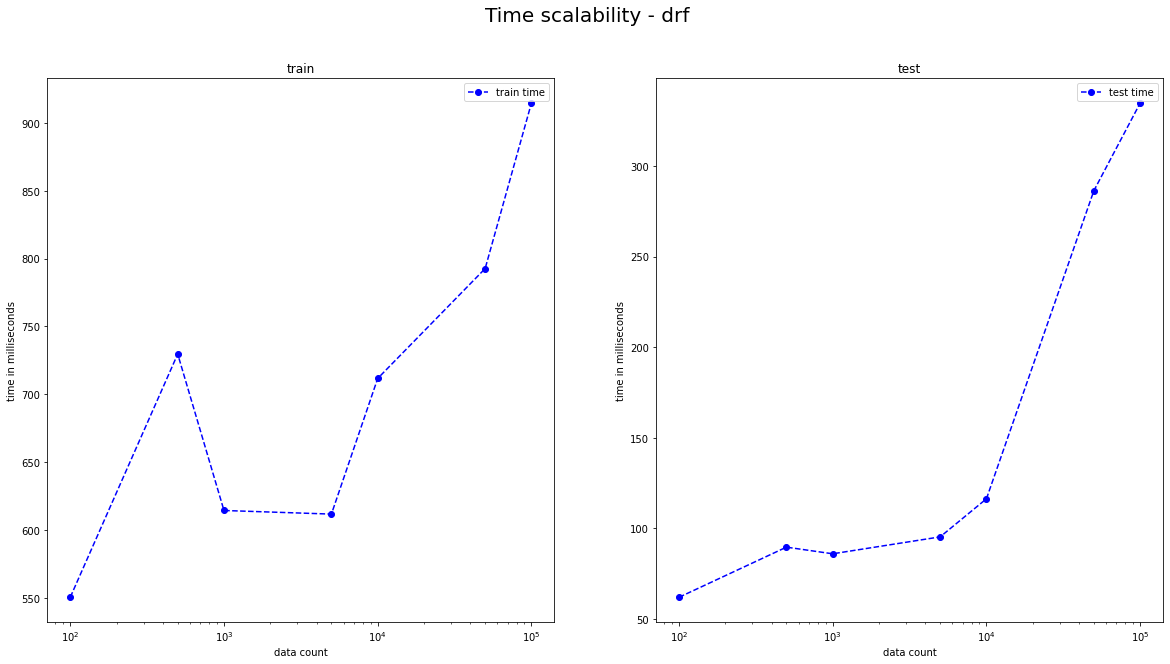

In [69]:
evaluate_time_scalability()